In [1]:
import os
import sys

_path = os.path.abspath('../')
if _path not in sys.path:
    sys.path.append(_path)

from pathlib import Path
import requests

from astropy.constants import c as speed_of_light
import astropy.coordinates as coord
from astropy.io import fits
import astropy.table as at
from astropy.time import Time
import astropy.units as u
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from scipy.interpolate import InterpolatedUnivariateSpline

from astropy.nddata import StdDevUncertainty
from specutils.spectra import Spectrum1D

from subframe.data import Visit
from subframe.config import sdss_auth, plot_path, allstar_path, allvisit_path
from subframe.log import logger
from subframe.velocity import (bag_of_hacks_cross_correlate, shift_and_interpolate, 
                               estimate_rv)
from subframe.utils import parabola_optimum
from subframe.plot import plot_spectrum, plot_visit_frames, plot_normalized_ref_spectrum
from subframe.data_helpers import apply_masks

In [2]:
allstar = at.Table.read(allstar_path, hdu=1)
allvisit = at.Table.read(allvisit_path, hdu=1)

In [22]:
def stellar_radius(logg, mass):
    from astropy.constants import G
    return np.sqrt(G*mass / (10**logg*u.cm/u.s**2)).to(u.Rsun)

In [57]:
def get_nu_max(logg, teff, M=1.1*u.Msun):
    nu_max_sun = 3090 * u.microHertz
    Teff_sun = 5777 * u.K

    R = stellar_radius(logg, M)
    Teff = teff * u.K

    nu_max = nu_max_sun * (M / u.Msun) * (R / u.Rsun)**-2 * (Teff / Teff_sun)**-0.5
    return nu_max


def get_delta_rv_max(logg):
    slope = np.log(550) - np.log(2000)
    log_drv = slope * (logg - 0) + np.log(2e3)
    return np.exp(log_drv) * u.m/u.s

In [58]:
# (1 / get_nu_max(2.5, 5000)).to(u.hour)

In [86]:
mask = ((allstar['LOGG'] > 2.6) & (allstar['LOGG'] < 2.8) &
        (allstar['TEFF'] > 4500) & (allstar['TEFF'] < 5500) &
        (allstar['SNR'] > 300) & 
        (allstar['NVISITS'] >= 10) & 
        (allstar['VSCATTER'] < 2) &
        (allstar['STARFLAG'] == 0))
mask.sum()

101

In [87]:
apid = allstar['APOGEE_ID'][np.where(mask)][1]

star = allstar[allstar['APOGEE_ID'] == apid]
visits_tbl = allvisit[allvisit['APOGEE_ID'] == apid]
len(visits_tbl)

26

In [88]:
(1 / get_nu_max(star['LOGG'], star['TEFF'])).to(u.hour), get_delta_rv_max(star['LOGG'])

(<Quantity [5.000933 , 5.4907837] h>, <Quantity [65.5289 , 69.04829] m / s>)

<ErrorbarContainer object of 3 artists>

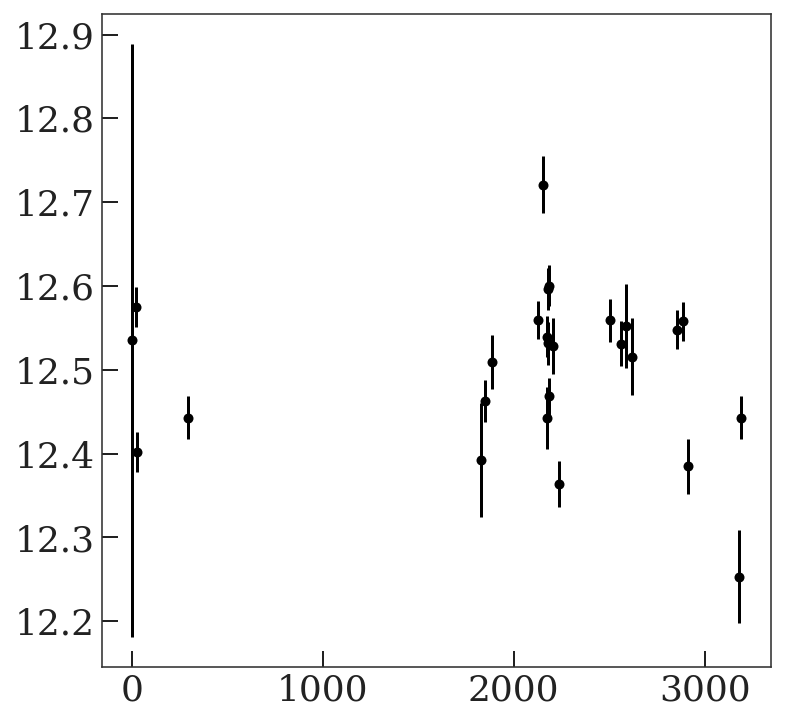

In [89]:
plt.errorbar(visits_tbl['JD'] - visits_tbl['JD'].min(),
             visits_tbl['VHELIO'],
             visits_tbl['VRELERR'],
             marker='o', ls='none')

In [91]:
visits = []
for row in visits_tbl:
    visit = Visit(row)
    frames = visit.frame_hdulists
    if frames is not None:
        visits.append(visit)
len(visits)

ConnectionError: HTTPSConnectionPool(host='data.sdss.org', port=443): Max retries exceeded with url: /sas/apogeework/apogee/spectro/redux/dr17/visit/apo25m/120-08-RV/9518/58059/apVisit-dr17-9518-58059-229.fits (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x1554d93d8a20>: Failed to establish a new connection: [Errno 110] Connection timed out'))

---

In [2]:
import exoplanet as xo
import exoplanet.units as xu
import pymc3 as pm
import thejoker as tj
from twobody import KeplerOrbit, KeplerElements

In [38]:
true_orbit = KeplerOrbit(
    P=12.5234*u.day,
    e=0.,
    i=90*u.deg,
    K=100*u.km/u.s,
    M0=0.8384*u.rad,
    omega=2.424*u.rad,
    t0=Time(55524., format='mjd', scale='tcb'))

ts = true_orbit.t0 + 645 + np.random.uniform(10, 200, size=30)
rvs = true_orbit.radial_velocity(ts)
rv_errs = np.ones_like(rvs)

In [39]:
rv_data = tj.RVData(
    ts,
    rvs,
    rv_errs
)

In [40]:
with pm.Model() as model:
    # Allow extra error to account for under-estimated error bars
    s = xu.with_unit(pm.Lognormal('s', 0, 1),
                     u.km/u.s)

    prior = tj.JokerPrior.default(
        P_min=4*u.day, P_max=20*u.day,
        sigma_K0=30*u.km/u.s,
        sigma_v=50*u.km/u.s,
        s=s)

joker = tj.TheJoker(prior)

In [41]:
samples = joker.rejection_sample(rv_data, 
                                 prior_samples=100_000)
len(samples)

1

In [42]:
mean_sample = samples

In [43]:
rv_data.t0

<Time object: scale='tcb' format='mjd' value=56195.31547440011>

In [44]:
mean_sample['M0'][0]

<Quantity -2.33313443 rad>

In [46]:
(2*np.pi * (rv_data.t0 - true_orbit.t0).jd * u.day / true_orbit.P) % (2*np.pi)

<Quantity 3.80063344>

In [31]:
mean_sample['M0'][0].value / (2*np.pi)

-0.39623598356851686

In [26]:
# t0 = mean_sample.t0 - mean_sample['P'][0] * mean_sample['M0'][0].to_value(u.rad) / (2*np.pi)
t0 = rv_data.t0 + (mean_sample['P'][0]/(2*np.pi)*mean_sample['M0'][0]).to(u.day, u.dimensionless_angles())
t0

<Time object: scale='tcb' format='mjd' value=55531.976394731064>

In [27]:
(t0.mjd - true_orbit.t0.mjd) / true_orbit.P.value

0.6369192656198731